In [1]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=1TBQWDOF3P32F3WKK43U
%env CLEARML_API_SECRET_KEY=H9PMCYs2RWKtyw1eQvOPBrcf9kXPGGV6jCKzA1knwycj2q0BDO

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=1TBQWDOF3P32F3WKK43U
env: CLEARML_API_SECRET_KEY=H9PMCYs2RWKtyw1eQvOPBrcf9kXPGGV6jCKzA1knwycj2q0BDO


In [6]:
import pandas as pd
import numpy as np
from clearml import Task, Logger
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterSampler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

In [7]:
task = Task.init(project_name='MlopsClearML2',  task_name='Titanic_Test', tags=['CatBoost','RandomSearch'])

ClearML Task: created new task id=9ef4ee1fa2c34b53b9fa6e9323483fe2
2023-12-25 13:22:00,497 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/e9c7e3f55cc34ffb8d5099b035052c90/experiments/9ef4ee1fa2c34b53b9fa6e9323483fe2/output/log


In [8]:
df_raw = pd.read_csv('/content/titanic.csv')
task.upload_artifact(name='data.raw', artifact_object='titanic.csv')

True

In [9]:
task.upload_artifact(
    name='Describe',
    artifact_object=df_raw.describe(include=object))

True

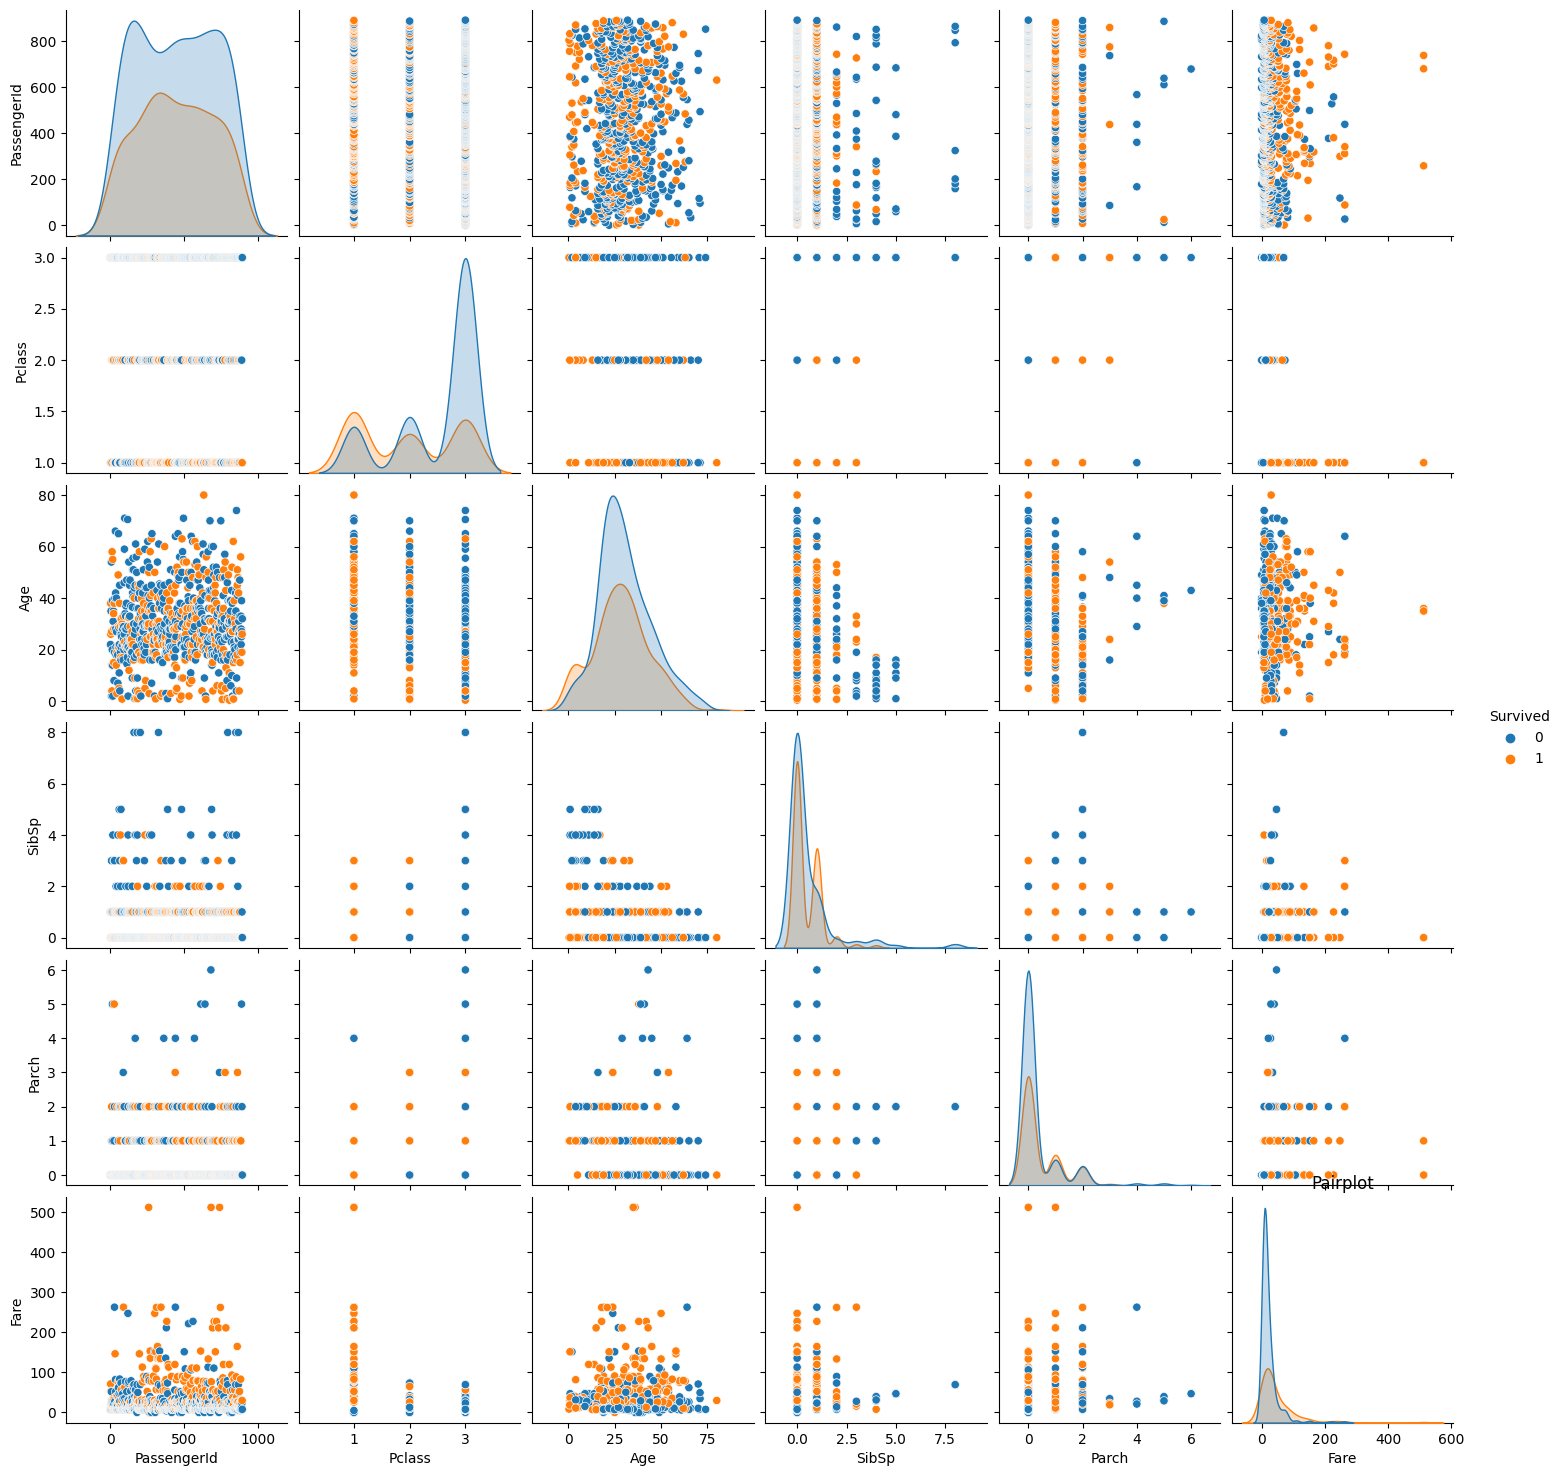

In [10]:
sns.pairplot(df_raw, hue='Survived')
plt.title('Pairplot')
plt.show()

In [11]:
df_raw = df_raw.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [12]:
df_raw
one_hot = pd.get_dummies(df_raw['Sex'])
df_raw = df_raw.drop('Sex',axis = 1)
df_raw = df_raw.join(one_hot)

one_hot = pd.get_dummies(df_raw['Embarked'])
df_raw = df_raw.drop('Embarked',axis = 1)
df_raw = df_raw.join(one_hot)
df_raw['Cabin'].fillna(0, inplace=True)
df_raw['Cabin'][df_raw['Cabin'] != 0] = 1

<ipython-input-12-dd1fae41e455>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
df_raw

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,1,0,0,0,1
888,0,3,NaN,1,2,23.4500,0,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,1,0,1,1,0,0


In [14]:
train, test = train_test_split(df_raw, test_size=0.2, random_state=42)
task.upload_artifact(name='data.train', artifact_object=train)
task.upload_artifact(name='data.test', artifact_object=test)

True

In [15]:
X_train = train.drop(columns=['Survived'], axis=1)
y_train = train['Survived']

model = CatBoostClassifier(iterations = 100)
model.fit(X_train, y_train);

Learning rate set to 0.073611
0:	learn: 0.6673484	total: 47.1ms	remaining: 4.67s
1:	learn: 0.6435072	total: 47.6ms	remaining: 2.33s
2:	learn: 0.6216123	total: 48ms	remaining: 1.55s
3:	learn: 0.6025104	total: 48.4ms	remaining: 1.16s
4:	learn: 0.5850688	total: 48.8ms	remaining: 928ms
5:	learn: 0.5693719	total: 49.4ms	remaining: 774ms
6:	learn: 0.5557958	total: 49.9ms	remaining: 663ms
7:	learn: 0.5432019	total: 50.3ms	remaining: 578ms
8:	learn: 0.5322378	total: 50.8ms	remaining: 514ms
9:	learn: 0.5207083	total: 52.6ms	remaining: 473ms
10:	learn: 0.5111198	total: 53.1ms	remaining: 430ms
11:	learn: 0.5022091	total: 53.6ms	remaining: 393ms
12:	learn: 0.4945865	total: 54.4ms	remaining: 364ms
13:	learn: 0.4874614	total: 55.1ms	remaining: 338ms
14:	learn: 0.4818115	total: 55.7ms	remaining: 315ms
15:	learn: 0.4759110	total: 56.1ms	remaining: 294ms
16:	learn: 0.4707982	total: 56.6ms	remaining: 276ms
17:	learn: 0.4661199	total: 57.1ms	remaining: 260ms
18:	learn: 0.4614621	total: 57.6ms	remaining: 

In [16]:
from sklearn.metrics import accuracy_score

X_test = test.drop(columns=['Survived'], axis=1)
y_test = test['Survived']

score = accuracy_score(y_test, model.predict(X_test))

In [17]:
score

0.8100558659217877

In [18]:
task.upload_artifact(name='Score 1', artifact_object={'score:': score})

True

In [19]:

model.save_model('my_model.cbm')

In [20]:
param_grid = {
    'depth': [3,4,5,6,7,8],
    'iterations': [100, 200, 500, 1000]
}

# Формируем датасет для тестирования
X_test = test.drop(columns=['Survived'])
y_test = test['Survived']

# Инциируем объект логирования
log = Logger.current_logger()

# Переменные для хранения результатов
best_score = 0
best_model = None
i = 0

# Перебираем случайные 50 гиперпараметров
for param in ParameterSampler(param_grid, n_iter=50, random_state=42):
    # Обучаем модель
    model = CatBoostClassifier(**param, silent=True)
    model.fit(X_train, y_train)

    # Оцениваем модель
    test_scores = model.eval_metrics(
        data=Pool(X_test, y_test),
        metrics=['Logloss','AUC'])
    test_logloss  = round(test_scores['Logloss'][-1], 4)
    test_roc_auc = round(test_scores['AUC'][-1]*100, 1)

    train_scores = model.eval_metrics(
        data=Pool(X_train, y_train),
        metrics=['Logloss','AUC'])
    train_logloss  = round(train_scores['Logloss'][-1], 4)
    train_roc_auc = round(train_scores['AUC'][-1]*100, 1)

    # Сравниваем текущий скор с лучшим
    if test_roc_auc > best_score:
        # Сохраняем модель
        best_score = test_roc_auc
        best_model = model

        # Записываем метрики в ClearML
        log.report_scalar("Logloss", "Test", iteration=i, value=test_logloss)
        log.report_scalar("Logloss", "Train", iteration=i, value=train_logloss)

        log.report_scalar("ROC AUC", "Test", iteration=i, value=test_roc_auc)
        log.report_scalar("ROC AUC", "Train", iteration=i, value=train_roc_auc)

        i+=1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.



In [21]:
best_model

In [22]:
from sklearn.metrics import accuracy_score

X_test = test.drop(columns=['Survived'], axis=1)
y_test = test['Survived']

score_2 = accuracy_score(y_test, best_model.predict(X_test))

In [23]:
task.upload_artifact(name='Score Best', artifact_object={'score:': score_2})

True

In [24]:
log.report_single_value(name='Score', value=score)

In [25]:
log.report_single_value(name='Best score', value=score_2)

In [26]:
score_2

0.8156424581005587